In [1063]:
from syntax_sugar import END, pipe
from syntax_sugar import process_syntax as p
from syntax_sugar import thread_syntax as t
NTHR = 16
import os
from os.path import join

In [1064]:
from scipy.integrate import quad

import TMQGP as tm
from numpy import *

import QuarkTM
from QuarkTM import Channel, ChannelGroup, ChannelL, Particle

import matplotlib
matplotlib.style.use('publication23')

mQ = 0.6


qrange = linspace(0, 5, 151)
erange = linspace(-5, 5, 401)
eps = 10e-2
# pt = QuarkTM.Particle(mQ, qrange, erange, eps=5e-2)

G = 5
L = 0.5
screen = 0
G1 = 5/3

# ch = QuarkTM.Channel(pt, pt, T, G=8, screen=0, ds=4, da=1, Fa=1)

import tqdm

from scipy.optimize import minimize

params = {'G' : G, 'L' : L, 'screen' : screen}
params1 = {'G' : G1, 'L' : L, 'screen' : screen}
pss = [params, params1]
mu = 0
lmax = 0

In [1065]:
T = 0.2

In [1066]:
ImS_Ks = [[-eps for q in qrange]]*2
ImS_K_Arr = array([[-eps for e in erange] for q in qrange]).transpose()
ImS_K_Arrs = [ImS_K_Arr, ImS_K_Arr]
ReS = array([[0. for e in erange] for q in qrange]).transpose()
omk = sqrt(mQ**2 + qrange**2)
omKs = [omk, omk]

In [1067]:
omArrs = [array([omK for e in erange]) for omK in omKs]
ImS_K_Arrs = [array([ImS_K for e in erange]) for ImS_K in ImS_Ks]

In [1068]:
eArr = array([erange for q in qrange]).transpose()

In [1069]:
mu = 0 * T
delta = 1.

In [821]:
import warnings
warnings.filterwarnings('ignore')

In [822]:
def f(x, T):
    return 1/(exp(x/T) + 1)

Start of iterations

In [823]:
G2_QQ = (1 - 2*f(omArrs[0], T)) / (eArr - 2*omArrs[0] - 1j*2*ImS_K_Arrs[0] + 2*mu)
G2_QA = (1 - f(omArrs[0], T) - f(omArrs[1], T)) / (eArr - omArrs[0] - omArrs[1] - 1j*(ImS_K_Arrs[0] + ImS_K_Arrs[1]))
G2_AA = (1 - 2*f(omArrs[1], T)) / (eArr - 2*omArrs[1] - 1j*2*ImS_K_Arrs[1] - 2*mu)

In [824]:
quark_run = Particle(mQ, qrange, erange, eps=eps, mu=mu)
aquark_run = Particle(mQ, qrange, erange, eps=eps, mu=mu)

In [825]:
channels_QQ = QuarkTM.ChannelGroup(mu0=False)
channels_QA = QuarkTM.ChannelGroup(mu0=False)

channels_QQ.addChannel(
    QuarkTM.ChannelL('qq3', lmax, quark_run, quark_run, T, pss, ds=4, da=3, Fa=1/2, mu=mu, G2=G2_QQ)
)

channels_QA.addChannel(
    QuarkTM.ChannelL('qa1', lmax, quark_run, aquark_run, T, pss, ds=4, da=1, Fa=1, mu=mu, G2=G2_QA)
)

channels_AA = QuarkTM.ChannelGroup(mu0=False)
channels_AQ = QuarkTM.ChannelGroup(mu0=False)

channels_AA.addChannel(
    QuarkTM.ChannelL('aa3', lmax, aquark_run, aquark_run, T, pss, ds=4, da=3, Fa=1/2, mu=mu, G2=G2_QA)
)

channels_AQ.addChannel(
    QuarkTM.ChannelL('aq1', lmax, aquark_run, quark_run, T, pss, ds=4, da=1, Fa=1, mu=mu, G2=G2_AA)
)

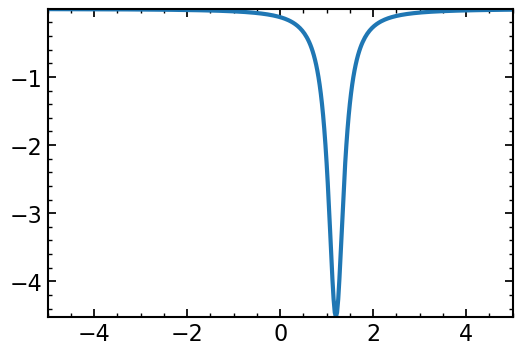

In [826]:
plt.plot(erange, imag(channels_AA.channels['aa3'].chs[0].G2[:, 0]))
# plt.plot(erange, imag(G2_AA[:, 0]), ls=':')

## 1-channel test

In [827]:
TM = channels_QA.get_T()

In [828]:
# TM = ch.TM.copy()
TM[erange < 0] = real(TM[erange < 0])

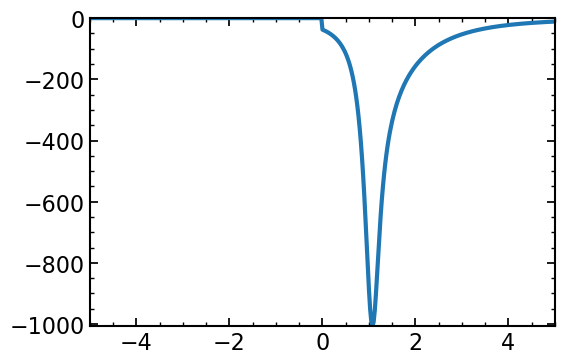

In [829]:
plt.plot(erange, imag(TM[:, 0]))

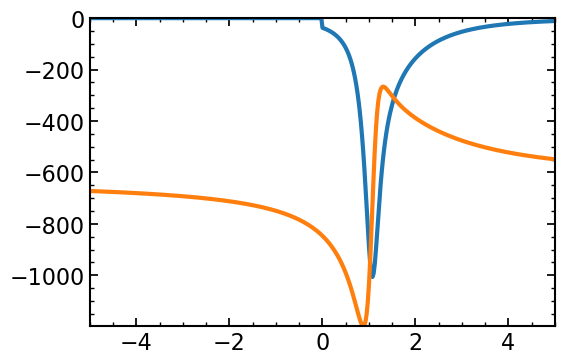

In [830]:
plt.plot(erange, imag(TM[:, 0]))
plt.plot(erange, real(TM[:, 0]))

In [831]:
iEps = tm.Interpolator(qrange, sqrt(qrange**2 + mQ**2), 'cubic')

In [832]:
iImTM = tm.InterDenom2D(qrange, erange, ascontiguousarray(nan_to_num(real(1/TM), posinf=0, neginf=0)), 
            ascontiguousarray(nan_to_num(imag(1/TM), posinf=0, neginf=0)), 'imag')
iReTM = tm.InterDenom2D(qrange, erange, ascontiguousarray(nan_to_num(real(1/TM), posinf=0, neginf=0)), 
            ascontiguousarray(nan_to_num(imag(1/TM), posinf=0, neginf=0)), 'real')

In [833]:
tm.SigmaQP(mQ, 0, T, iReTM, quark_run.R, iEps, iEps, 0, 0)

-0.028624154029549716

In [834]:
tm.SigmaQP(mQ, 0, T, iImTM, quark_run.R, iEps, iEps, 0, 0)

-0.05594623434805591

Check the energy dependence

In [835]:
re = array([tm.SigmaQP(e, 0, T, iReTM, quark_run.R, iEps, iEps, 0, 0) for e in erange])
im = array([tm.SigmaQP(e, 0, T, iImTM, quark_run.R, iEps, iEps, 0, 0) for e in erange])

In [836]:
iIm = tm.Interpolator(erange, im, 'cubic')

In [837]:
re_kk = array([tm.ReSigmaKK(e, iIm) for e in erange])

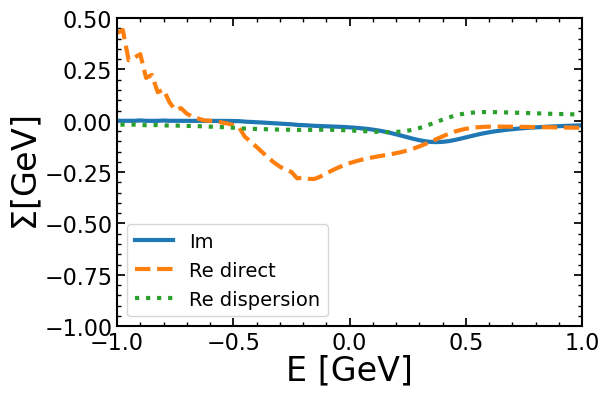

In [838]:
plt.plot(erange, im, label='Im')
plt.plot(erange, re, ls='--', label='Re direct')
plt.plot(erange, re_kk, ls=':', label='Re dispersion')

plt.xlim(-1, 1)
plt.ylim(-1, 0.5)

plt.xlabel('E [GeV]')
plt.ylabel(r'$\Sigma [GeV]$')
plt.legend(fontsize=14)

plt.savefig('re_compare.pdf', bbox_inches='tight')

## Solve the equation iteratively

In [839]:
mu = 0

In [840]:
ReS_K = array([0 for q in qrange])
ImS_K = array([-5e-2 for q in qrange])

In [841]:

channels_QQ.addChannel(
    QuarkTM.ChannelL('qq3', lmax, quark_run, quark_run, T, pss, ds=4, da=3, Fa=1/2, mu=mu, G2=G2_QQ)
)

channels_QA.addChannel(
    QuarkTM.ChannelL('qa1', lmax, quark_run, aquark_run, T, pss, ds=4, da=1, Fa=1, mu=mu, G2=G2_QA)
)

channels_AA = QuarkTM.ChannelGroup(mu0=False)
channels_AQ = QuarkTM.ChannelGroup(mu0=False)

channels_AA.addChannel(
    QuarkTM.ChannelL('aa3', lmax, aquark_run, aquark_run, T, pss, ds=4, da=3, Fa=1/2, mu=mu, G2=G2_QA)
)

channels_AQ.addChannel(
    QuarkTM.ChannelL('aq1', lmax, aquark_run, quark_run, T, pss, ds=4, da=1, Fa=1, mu=mu, G2=G2_AA)
)

In [842]:
def eq(x, k, T, ReS_K, ImS_K):
    ImS_K_Arr = array([ImS_K for e in erange])
    ReS_K_Arr = array([ReS_K for e in erange])
    
    omArr = array([sqrt(mQ**2 + qrange**2) for e in erange]) + ReS_K_Arr
    
    G2_QQ = (1 - 2*f(omArr, T)) / (eArr - 2*omArr - 1j*2*ImS_K_Arr + 2*mu)
    # G2_QA = (1 - f(omArrs[0], T) - f(omArrs[1], T)) / (eArr - omArrs[0] - omArrs[1] - 1j*(ImS_K_Arrs[0] + ImS_K_Arrs[1]))
    # G2_AA = (1 - 2*f(omArrs[1], T)) / (eArr - 2*omArrs[1] - 1j*2*ImS_K_Arrs[1] - 2*mu)
    channels_QQ = QuarkTM.ChannelGroup(mu0=True)
    
    # ch_L = QuarkTM.ChannelL('qa1', lmax, quark_run, aquark_run, T, pss, ds=4, da=1, Fa=1, mu=mu, G2=G2_QQ)
    # channels_QQ.addChannel(
    #     QuarkTM.ChannelL('qq3', lmax, quark_run, quark_run, T, pss, ds=4, da=3, Fa=1/2, mu=mu, G2=G2_QQ)
    # )

    channels_QQ.addChannel(
        QuarkTM.ChannelL('qa1', lmax, quark_run, aquark_run, T, pss, ds=4, da=1, Fa=1, mu=mu, G2=G2_QQ)
    )

    channels_QQ.addChannel(
        QuarkTM.ChannelL('qq3', lmax, quark_run, quark_run, T, pss, ds=4, da=3, Fa=1/2, mu=mu, G2=G2_QQ)
    )


    TM = channels_QQ.get_T()
    # TM = array([[0. for q in qrange] for e in erange])
    TM[erange < 0] = real(TM[erange < 0])
    # plt.plot(erange, real(TM[:, 0]))
    
    # iImTM = tm.InterDenom2D(qrange, erange, ascontiguousarray(nan_to_num(real(1/TM), posinf=0, neginf=0)), 
    #         ascontiguousarray(nan_to_num(imag(1/TM), posinf=0, neginf=0)), 'imag')
    # iReTM = tm.InterDenom2D(qrange, erange, ascontiguousarray(nan_to_num(real(1/TM), posinf=0, neginf=0)), 
    #             ascontiguousarray(nan_to_num(imag(1/TM), posinf=0, neginf=0)), 'real')

    iImTM = tm.Interpolator2D(qrange, erange, ascontiguousarray(imag(TM)))
    iReTM = tm.Interpolator2D(qrange, erange, ascontiguousarray(real(TM)))
    iEps = tm.Interpolator(qrange, sqrt(qrange**2 + mQ**2) + ReS_K, 'cubic')
    
    re = tm.SigmaQP(float(x), k, T, iReTM, quark_run.R, iEps, iEps, 0, 0)
    im = tm.SigmaQP(float(x), k, T, iImTM, quark_run.R, iEps, iEps, 0, 0)
    # re = 0
    # im = 0
    sol = float(x) - sqrt(mQ**2 + k**2) - re
    # print(x, sol)
    # del iImTM, iReTM, iEps
    
    return sol, re, im, TM


        

In [843]:
eq(0.7, 0, T, ReS_K, ImS_K)

(0.18735748721615714,
 -0.08735748721615716,
 -0.09013220815515428,
 array([[-1.64675964e+03+0.00000000e+00j, -1.62719658e+03+0.00000000e+00j,
         -1.57034636e+03+0.00000000e+00j, ...,
         -2.48151152e-03+0.00000000e+00j, -2.38435999e-03+0.00000000e+00j,
         -2.29161006e-03+0.00000000e+00j],
        [-1.64705742e+03+0.00000000e+00j, -1.62749082e+03+0.00000000e+00j,
         -1.57063033e+03+0.00000000e+00j, ...,
         -2.48196025e-03+0.00000000e+00j, -2.38479115e-03+0.00000000e+00j,
         -2.29202444e-03+0.00000000e+00j],
        [-1.64735756e+03+0.00000000e+00j, -1.62778740e+03+0.00000000e+00j,
         -1.57091654e+03+0.00000000e+00j, ...,
         -2.48241253e-03+0.00000000e+00j, -2.38522573e-03+0.00000000e+00j,
         -2.29244212e-03+0.00000000e+00j],
        ...,
        [-1.42519636e+03-1.73905115e+01j, -1.40826541e+03-1.71839169e+01j,
         -1.35906411e+03-1.65835534e+01j, ...,
         -2.14763655e-03-2.62058612e-05j, -2.06355627e-03-2.51798980e-05j,
  

In [844]:
from scipy.optimize import minimize

In [845]:
# # for i in range(1000):
# sols = []
# ReS_K = array([0 for q in qrange])
# ImS_K = array([-5e-2 for q in qrange])

# init = 0.6
# qrange_sol = linspace(0, 5, 21)

# ress = []
# imss = []
# TMs = []

# for q in tqdm.notebook.tqdm(qrange_sol):
#     # init = sqrt(mQ**2 + q**2)
#     sol = minimize(lambda z: eq(z, q, T, ReS_K, ImS_K)[0]**2, [init]).x
#     sol = float(sol)
    
#     func, re, im, TM = eq(sol, q, T, ReS_K, ImS_K)
#     print('q=', q, 'sol =', sol, 're, im = ', re, im)

#     if isnan(re):
#         break
#     sols += [sol]
#     init = sol

#     ress += [re]
#     imss += [im]
#     TMs += [TM]
    
#     if abs(im) < 0.01:
#         im = -0.01
    
#     ReS_K = array([re for q in qrange])
#     ImS_K = array([im for q in qrange])
#     init = sol

In [846]:
ImS_K_Arr = array([ImS_K for e in erange])
ReS_K_Arr = array([ReS_K for e in erange])

omArr = array([sqrt(mQ**2 + qrange**2) for e in erange]) + ReS_K_Arr

G2_QQ = (1 - 2*f(omArr, T)) / (eArr - 2*omArr - 1j*2*ImS_K_Arr + 2*mu)

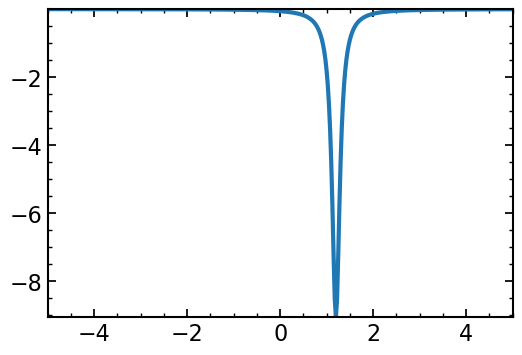

In [847]:
plt.plot(erange, imag(G2_QQ[:, 0]))

In [848]:
iReTM(0.5, 0.5)

-146.2389438978036

In [849]:
# plt.plot(qrange_sol, sols, label='selfcons.')
# plt.plot(qrange, sqrt(mQ**2 + qrange**2), ls=':', label='free')

# plt.xlim(0, 2)
# plt.ylim(0, 2.5)
# plt.xlabel('k [GeV]')
# plt.ylabel(r'$\varepsilon(k) [GeV]$')

# plt.legend()
# plt.savefig('omK.pdf', bbox_inches='tight')

In [915]:
# plt.plot(qrange_sol, ress, label='Re')
# plt.plot(qrange_sol, imss, label='Im', ls='--')

# plt.ylabel(r'$\Sigma(\omega_k, k) [GeV]$')
# plt.xlabel('k [GeV]')

# plt.axhline(-0.01, ls='--', lw=1, c='black')
# plt.legend()

# plt.ylim(-0.2, 0)

# plt.savefig(
#     'sigma_k_1ch.pdf', bbox_inches='tight')

In [986]:
lmax = 0

In [1044]:
if len(ims) == 0 or len(res) == 0:
    ims = array([-eps for q in qrange])
    res = array([0. for q in qrange])

ImS_K_Arr = array([ims for e in erange])
ReS_K_Arr = array([res for e in erange])

omArr = array([sqrt(mQ**2 + qrange**2) for e in erange]) + ReS_K_Arr

G2_QQ = (1 - 2*f(omArr, T)) / (eArr - 2*omArr - 1j*2*ImS_K_Arr + 2*mu)
G2_QA = (1 - f(omArrs[0], T) - f(omArrs[1], T)) / (eArr - omArrs[0] - omArrs[1] - 1j*(ImS_K_Arrs[0] + ImS_K_Arrs[1]))
G2_AA = (1 - 2*f(omArrs[1], T)) / (eArr - 2*omArrs[1] - 1j*2*ImS_K_Arrs[1] - 2*mu)

channels_QQ = QuarkTM.ChannelGroup(mu0=True)

# ch_L = QuarkTM.ChannelL('qa1', lmax, quark_run, aquark_run, T, pss, ds=4, da=1, Fa=1, mu=mu, G2=G2_QQ)
channels_QQ.addChannel(
    QuarkTM.ChannelL('qq3', lmax, quark_run, quark_run, T, pss, ds=4, da=3, Fa=1/2, mu=mu, G2=G2_QQ)
)

channels_QQ.addChannel(
    QuarkTM.ChannelL('qa1', lmax, quark_run, aquark_run, T, pss, ds=4, da=1, Fa=1, mu=mu, G2=G2_QQ)
)

# channels_QQ_0 = QuarkTM.ChannelGroup(mu0=True)

# # ch_L = QuarkTM.ChannelL('qa1', lmax, quark_run, aquark_run, T, pss, ds=4, da=1, Fa=1, mu=mu, G2=G2_QQ)
# # channels_QQ_0.addChannel(
# #     QuarkTM.ChannelL('qq3', 0, quark_run, quark_run, T, pss, ds=4, da=3, Fa=1/2, mu=mu, G2=G2_QQ)
# # )

# channels_QQ_0.addChannel(
#     QuarkTM.ChannelL('qa1', 0, quark_run, aquark_run, T, pss, ds=4, da=1, Fa=1, mu=mu, G2=G2_QQ)
# )


TM_vac = channels_QQ.get_T()
TM_vac = TM_vac #- (TM_vac[0, :] + TM_vac[-1, :])/2
TM_0 = channels_QQ_0.get_T()

In [1045]:
TM_qa_0 = channels_QQ.channels['qa1'].chs[0].TM
TM_qa_1 = 3*channels_QQ.channels['qa1'].chs[1].TM

IndexError: list index out of range

In [1046]:
# TM_qq_0 = channels_QQ.channels['qq3'].chs[0].TM
# TM_qq_1 = 3*channels_QQ.channels['qq3'].chs[1].TM

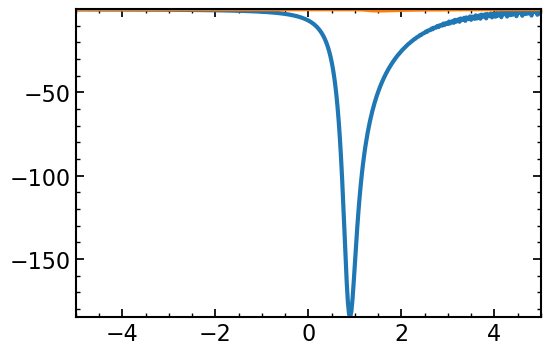

In [1047]:
plt.plot(erange, imag(TM_qa_0[:, 10]))
plt.plot(erange, imag(TM_qa_1[:, 10]))

In [1048]:
qrange[40]

1.3333333333333333

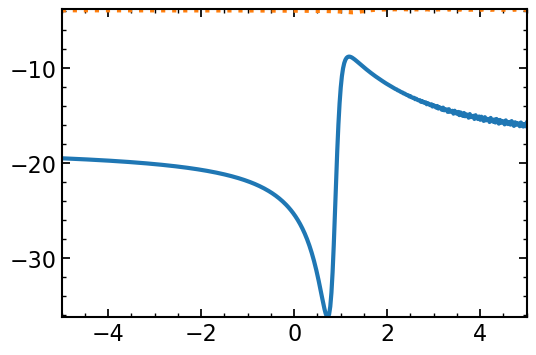

In [1049]:
plt.plot(erange, real(TM_qa_0[:, 20]))
plt.plot(erange, real(TM_qa_1[:, 20]), ls=':')

In [1050]:
qrange[20]

0.6666666666666666

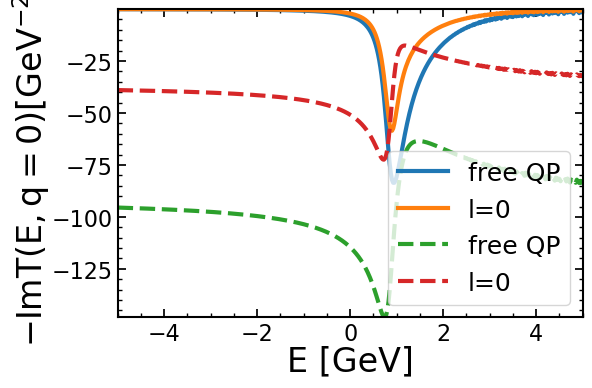

In [1051]:
# plt.plot(erange, imag(TM[:, 0]), label='Self-cons. QP')
# plt.plot(erange, real(TM[:, 0]), label='Self-cons. QP', ls=':')
plt.plot(erange, imag(TM_vac[:, 20]), ls='-', label='free QP')
plt.plot(erange, imag(TM_0[:, 20]), ls='-', label='l=0')
plt.plot(erange, real(TM_vac[:, 20]), ls='--', label='free QP')
plt.plot(erange, real(TM_0[:, 20]), ls='--', label='l=0')

# plt.semilogy()
plt.xlim(-5, 5)

plt.ylabel('$-Im T(E, q=0) [GeV^{-2}]$')
plt.xlabel('E [GeV]')
plt.legend()

# plt.savefig('TM.pdf', bbox_inches='tight')

In [1052]:
TM = TM_vac.copy()
TM[erange < 0] = real(TM[erange < 0])
TM

array([[-1.64661676e+03+0.00000000e+00j, -1.62705539e+03+0.00000000e+00j,
        -1.57021011e+03+0.00000000e+00j, ...,
        -2.48129621e-03+0.00000000e+00j, -2.38415311e-03+0.00000000e+00j,
        -2.29141122e-03+0.00000000e+00j],
       [-1.64692093e+03+0.00000000e+00j, -1.62735595e+03+0.00000000e+00j,
        -1.57050016e+03+0.00000000e+00j, ...,
        -2.48175456e-03+0.00000000e+00j, -2.38459352e-03+0.00000000e+00j,
        -2.29183450e-03+0.00000000e+00j],
       [-1.64722757e+03+0.00000000e+00j, -1.62765894e+03+0.00000000e+00j,
        -1.57079257e+03+0.00000000e+00j, ...,
        -2.48221664e-03+0.00000000e+00j, -2.38503750e-03+0.00000000e+00j,
        -2.29226121e-03+0.00000000e+00j],
       ...,
       [-1.42555982e+03-1.02515876e+01j, -1.40862455e+03-1.01298015e+01j,
        -1.35941070e+03-9.77589131e+00j, ...,
        -2.14818425e-03-1.54481759e-05j, -2.06408253e-03-1.48433777e-05j,
        -1.98379116e-03-1.42659806e-05j],
       [-1.44106174e+03-1.08501717e+01j, -1.

In [1053]:
real(TM).shape

(401, 151)

In [1054]:
imag(TM).shape

(401, 151)

In [1055]:
any(isnan(real(TM)))

False

In [1056]:
qrange.shape, erange.shape

((151,), (401,))

In [1057]:
iReTM = tm.Interpolator2D(qrange, erange, ascontiguousarray(real(TM)))

In [1058]:
iImTM = tm.Interpolator2D(qrange, erange, ascontiguousarray(imag(TM)))

In [1059]:
re = 0

In [1060]:
omK = []
res = []
ims = []

for k in tqdm.notebook.tqdm(qrange):
    delta = 1
    x = sqrt(mQ**2 + k**2)
    re = 0
    while delta > 1e-3:
        
        # plt.plot(erange, real(TM[:, 0]))
        
        # iImTM = tm.InterDenom2D(qrange, erange, ascontiguousarray(nan_to_num(real(1/TM), posinf=0, neginf=0)), 
        #         ascontiguousarray(nan_to_num(imag(1/TM), posinf=0, neginf=0)), 'imag')
        # iReTM = tm.InterDenom2D(qrange, erange, ascontiguousarray(nan_to_num(real(1/TM), posinf=0, neginf=0)), 
        #             ascontiguousarray(nan_to_num(imag(1/TM), posinf=0, neginf=0)), 'real')
        
        iEps = tm.Interpolator(qrange, sqrt(qrange**2 + mQ**2) + ReS_K, 'cubic')
        
        re = tm.SigmaQP(float(x), k, T, iReTM, quark_run.R, iEps, iEps, 0, 0)
        im = tm.SigmaQP(float(x), k, T, iImTM, quark_run.R, iEps, iEps, 0, 0)
        x0 = x
        x = sqrt(mQ**2 + k**2) + re
        delta = abs(x - x0)
        print('k = ', k, 'delta = ', delta)
    omK += [x]
    res += [re]
    ims += [im]

  0%|          | 0/151 [00:00<?, ?it/s]

k =  0.0 delta =  0.11481614220341985
k =  0.0 delta =  0.013587251002438183
k =  0.0 delta =  0.0026529814273289487
k =  0.0 delta =  0.0005536384798908722
k =  0.03333333333333333 delta =  0.11457580132757533
k =  0.03333333333333333 delta =  0.0135018468646399
k =  0.03333333333333333 delta =  0.002623871795650934
k =  0.03333333333333333 delta =  0.0005447787862469244
k =  0.06666666666666667 delta =  0.11386140165677572
k =  0.06666666666666667 delta =  0.013250304640235355
k =  0.06666666666666667 delta =  0.002538976671060511
k =  0.06666666666666667 delta =  0.0005192138695274129
k =  0.1 delta =  0.11269254829651815
k =  0.1 delta =  0.012846140605706435
k =  0.1 delta =  0.0024052193695501822
k =  0.1 delta =  0.0004797682388594793
k =  0.13333333333333333 delta =  0.11110007416516976
k =  0.13333333333333333 delta =  0.012310040224389307
k =  0.13333333333333333 delta =  0.0022328452113632435
k =  0.13333333333333333 delta =  0.00043047269713952785
k =  0.16666666666666666 d

(0.0, 2.5)

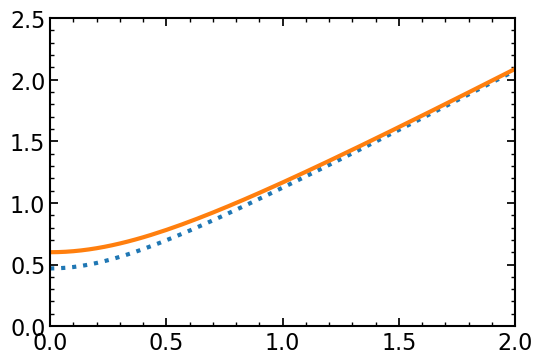

In [1061]:
plt.plot(qrange, omK, ls=':')
plt.plot(qrange, sqrt(mQ**2 + qrange**2))

plt.xlim(0, 2)
plt.ylim(0, 2.5)

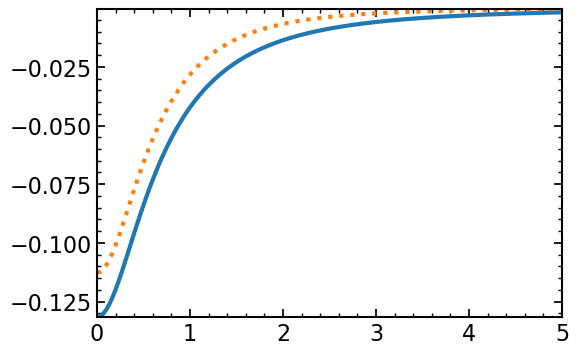

In [1062]:
plt.plot(qrange, res)
plt.plot(qrange, ims, ls=':')